In [2]:
# Iimporting libraries

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [5]:
import matplotlib

In [42]:
# Checking the version
np.__version__, torch.__version__, matplotlib.__version__

('2.1.2', '2.7.1+cu118', '3.10.7')

In [27]:
corpus_raw = ["apple banana fruit", "banana apple fruit", "banana fruit apple",
                 "dog cat animal", "cat animal dog", "cat dog animal"]

In [28]:
corpus = [sentence.split(" ") for sentence in corpus_raw]

In [29]:
corpus

[['apple', 'banana', 'fruit'],
 ['banana', 'apple', 'fruit'],
 ['banana', 'fruit', 'apple'],
 ['dog', 'cat', 'animal'],
 ['cat', 'animal', 'dog'],
 ['cat', 'dog', 'animal']]

In [30]:
#get word sequences and unique words
flatten = lambda l: [item for sublist in l for item in sublist]
vocab = list(set(flatten(corpus)))
vocab

['cat', 'animal', 'banana', 'fruit', 'dog', 'apple']

In [31]:
#numericalization
word2index = {w: i for i, w in enumerate(vocab)}
print(word2index)

{'cat': 0, 'animal': 1, 'banana': 2, 'fruit': 3, 'dog': 4, 'apple': 5}


In [32]:
#vocab size
voc_size = len(vocab)
print(voc_size)

6


In [33]:
#append UNK
vocab.append('<UNK>')

In [34]:
#vocab size
voc_size = len(vocab)
print(voc_size)

7


In [35]:
word2index['<UNK>'] = 0

In [36]:
#just in case we need to use
index2word = {v:k for k, v in word2index.items()} 

In [37]:
index2word

{0: '<UNK>', 1: 'animal', 2: 'banana', 3: 'fruit', 4: 'dog', 5: 'apple'}

In [38]:
for c in corpus:
    print(c)

['apple', 'banana', 'fruit']
['banana', 'apple', 'fruit']
['banana', 'fruit', 'apple']
['dog', 'cat', 'animal']
['cat', 'animal', 'dog']
['cat', 'dog', 'animal']


In [48]:
word2index

{'cat': 0,
 'animal': 1,
 'banana': 2,
 'fruit': 3,
 'dog': 4,
 'apple': 5,
 '<UNK>': 0}

In [50]:
for sent in corpus:
    print((sent))

['apple', 'banana', 'fruit']
['banana', 'apple', 'fruit']
['banana', 'fruit', 'apple']
['dog', 'cat', 'animal']
['cat', 'animal', 'dog']
['cat', 'dog', 'animal']


In [91]:
def random_batch(batch_size, word_sequence):
    
    # Make skip gram of one size window
    skip_grams = []
    # loop each word sequence
    # we starts from 1 because 0 has no context
    # we stop at second last for the same reason
    for sent in corpus:
        for i in range(1, len(sent) - 1):
            target = word2index[sent[i]]
            context = [word2index[sent[i - 1]], word2index[sent[i + 1]]]
            for w in context:
                skip_grams.append([target, w])
    
    random_inputs = []
    random_labels = []
    random_index = np.random.choice(range(len(skip_grams)), batch_size, replace=False) #randomly pick without replacement
        
    for i in random_index:
        random_inputs.append([skip_grams[i][0]])  # target, e.g., 2
        random_labels.append([skip_grams[i][1]])  # context word, e.g., 3
            
    return np.array(random_inputs), np.array(random_labels)

In [94]:
#testing the method
batch_size = 2 # mini-batch size
input_batch, target_batch = random_batch(batch_size, corpus)

print("Input batch: ", input_batch)
print("Target: ", target_batch)

#we will convert them to tensor during training, so don't worry...

Input batch:  [[1]
 [1]]
Target:  [[0]
 [4]]


In [95]:
class Skipgram(nn.Module):
    
    def __init__(self, vocab_size, emb_size):
        super(Skipgram,self).__init__()
        self.embedding_v = nn.Embedding(vocab_size, emb_size)
        self.embedding_u = nn.Embedding(vocab_size, emb_size)
    
    def forward(self, center_words, target_words, all_vocabs):
        center_embeds = self.embedding_v(center_words) # [batch_size, 1, emb_size]
        target_embeds = self.embedding_u(target_words) # [batch_size, 1, emb_size]
        all_embeds    = self.embedding_u(all_vocabs) #   [batch_size, voc_size, emb_size]
        
        scores      = target_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)
        #[batch_size, 1, emb_size] @ [batch_size, emb_size, 1] = [batch_size, 1, 1] = [batch_size, 1]

        norm_scores = all_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)
        #[batch_size, voc_size, emb_size] @ [batch_size, emb_size, 1] = [batch_size, voc_size, 1] = [batch_size, voc_size]

        nll = -torch.mean(torch.log(torch.exp(scores)/torch.sum(torch.exp(norm_scores), 1).unsqueeze(1))) # log-softmax
        # scalar (loss must be scalar)    
            
        return nll # negative log likelihood

In [96]:
batch_size     = 2 # mini-batch size
embedding_size = 2 #so we can later plot
model          = Skipgram(voc_size, embedding_size)

optimizer = optim.Adam(model.parameters(), lr=0.001)

In [97]:
model

Skipgram(
  (embedding_v): Embedding(7, 2)
  (embedding_u): Embedding(7, 2)
)

In [98]:
def prepare_sequence(seq, word2index):
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index["<UNK>"], seq))
    return torch.LongTensor(idxs)

#use for the normalized term in the probability calculation
all_vocabs = prepare_sequence(list(vocab), word2index).expand(batch_size, len(vocab))  # [batch_size, voc_size]
all_vocabs.shape

torch.Size([2, 7])

In [99]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [100]:
import time

# Training
num_epochs = 5000
for epoch in range(num_epochs):
    
    start = time.time()
    
    input_batch, target_batch = random_batch(batch_size, corpus)
    input_batch  = torch.LongTensor(input_batch)  #[batch_size, 1]
    target_batch = torch.LongTensor(target_batch) #[batch_size, 1]

    optimizer.zero_grad()
    loss = model(input_batch, target_batch, all_vocabs)
    
    loss.backward()
    optimizer.step()
    
    end = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start, end)

    if (epoch + 1) % 1000 == 0:
        print(f"Epoch: {epoch + 1} | cost: {loss:.6f} | time: {epoch_mins}m {epoch_secs}s")

Epoch: 1000 | cost: 1.674876 | time: 0m 0s
Epoch: 2000 | cost: 0.928804 | time: 0m 0s
Epoch: 3000 | cost: 1.241215 | time: 0m 0s
Epoch: 4000 | cost: 0.754797 | time: 0m 0s
Epoch: 5000 | cost: 1.210750 | time: 0m 0s


In [101]:
#list of vocabs
vocab[:10]

['cat', 'animal', 'banana', 'fruit', 'dog', 'apple', '<UNK>']

In [102]:
word = vocab[0]

In [103]:
#numericalization
id = word2index[word]
id

0

In [104]:
id_tensor = torch.LongTensor([id])
id_tensor

tensor([0])

In [105]:
#get the embedding by averaging
v_embed = model.embedding_v(id_tensor)
u_embed = model.embedding_u(id_tensor)

v_embed, u_embed

(tensor([[ 2.5443, -2.2490]], grad_fn=<EmbeddingBackward0>),
 tensor([[0.7235, 0.5460]], grad_fn=<EmbeddingBackward0>))

In [106]:
#average to get the word embedding
word_embed = (v_embed + u_embed) / 2
word_embed[0][1]

tensor(-0.8515, grad_fn=<SelectBackward0>)

In [108]:
#let's write a function to get embedding given a word
def get_embed(word):
    id_tensor = torch.LongTensor([word2index[word]])
    v_embed = model.embedding_v(id_tensor)
    u_embed = model.embedding_u(id_tensor) 
    word_embed = (v_embed + u_embed) / 2 
    x, y = word_embed[0][0].item(), word_embed[0][1].item()

    return x, y

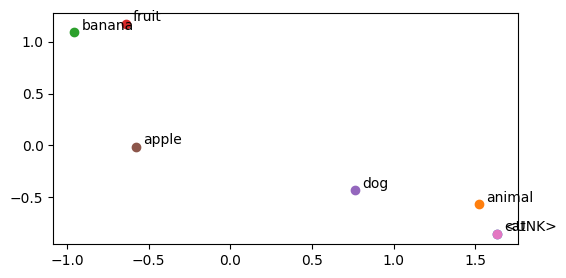

In [109]:
plt.figure(figsize=(6,3))
for i, word in enumerate(vocab[:20]): #loop each unique vocab
    x, y = get_embed(word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()

In [110]:
vocab

['cat', 'animal', 'banana', 'fruit', 'dog', 'apple', '<UNK>']

In [111]:
#let's try similarity between first and second, and second and third
cat          = get_embed('cat')
fruit        = get_embed('fruit')
animal       = get_embed('animal')

In [112]:
#numpy version
from numpy import dot
from numpy.linalg import norm

def cos_sim(a, b):
    cos_sim = dot(a, b)/(norm(a)*norm(b))
    return cos_sim
    
print(f"cat vs. fruit: ",        cos_sim(cat, fruit))
print(f"cat vs. animal: ",       cos_sim(cat, animal))
print(f"cat vs. cat: ",          cos_sim(cat, cat))

cat vs. fruit:  -0.8296616442067585
cat vs. animal:  0.9922819761022376
cat vs. cat:  1.0


In [113]:
#scipy version
from scipy import spatial

def cos_sim(a, b):
    cos_sim = 1 - spatial.distance.cosine(a, b)  #distance = 1 - similarlity, because scipy only gives distance
    return cos_sim

print(f"cat vs. fruit: ",        cos_sim(cat, fruit))
print(f"cat vs. animal: ",       cos_sim(cat, animal))
print(f"cat vs. cat: ",          cos_sim(cat, cat))

cat vs. fruit:  -0.8296616442067584
cat vs. animal:  0.9922819761022376
cat vs. cat:  1.0


In [114]:
from collections import Counter
import numpy as np

# 1) Count word frequencies from your tokenized corpus
word_counts = Counter([w for sent in corpus for w in sent])

# 2) Build a probability distribution over vocab indices
#    (exclude <UNK> from negatives if you want; here we include it only if it exists in counts)
vocab_words = [w for w in vocab if w != "<UNK>"]  # usually exclude UNK from negatives
vocab_indices = np.array([word2index[w] for w in vocab_words], dtype=np.int64)

freqs = np.array([word_counts[w] for w in vocab_words], dtype=np.float64)

# 3) Unigram^(3/4) distribution (Word2Vec default)
p = freqs ** 0.75
p = p / p.sum()

# Save these for later steps
NEG_VOCAB_INDICES = vocab_indices   # list of word indices you can sample from
NEG_SAMPLING_PROBS = p              # probabilities aligned with NEG_VOCAB_INDICES


In [115]:
p

array([0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
       0.16666667])

In [116]:
def sample_negative_words(batch_size, K):
    """
    Returns a tensor of shape [batch_size, K]
    Each row contains K negative word indices
    """
    neg_samples = np.random.choice(
        NEG_VOCAB_INDICES,          # possible word indices
        size=(batch_size, K),       # how many to draw
        replace=True,
        p=NEG_SAMPLING_PROBS        # use unigram^3/4 distribution
    )
    return torch.LongTensor(neg_samples)


In [117]:
def forward(self, center_words, target_words, negative_words):
    """
    center_words:  [batch_size, 1]
    target_words:  [batch_size, 1]     (positive context)
    negative_words:[batch_size, K]     (negative samples)
    """

    # 1) Lookup embeddings
    v_c = self.embedding_v(center_words)        # [B, 1, D]
    u_o = self.embedding_u(target_words)        # [B, 1, D]
    u_k = self.embedding_u(negative_words)      # [B, K, D]

    # 2) Positive score: u_o^T v_c
    pos_score = torch.bmm(u_o, v_c.transpose(1,2)).squeeze(2)  # [B, 1]

    # 3) Negative scores: u_k^T v_c
    neg_score = torch.bmm(u_k, v_c.transpose(1,2)).squeeze(2)  # [B, K]

    # 4) Apply sigmoid
    pos_loss = torch.log(torch.sigmoid(pos_score))            # [B, 1]
    neg_loss = torch.log(torch.sigmoid(-neg_score)).sum(1, keepdim=True)  # [B, 1]

    # 5) Final loss (negative log likelihood)
    loss = -(pos_loss + neg_loss).mean()

    return loss


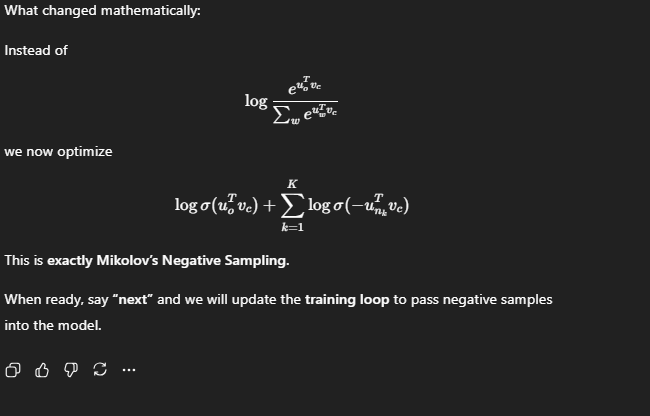

In [118]:
K = 5
for epoch in range(num_epochs):

    input_batch, target_batch = random_batch(batch_size, corpus)

    input_batch  = torch.LongTensor(input_batch)     # [B,1]
    target_batch = torch.LongTensor(target_batch)    # [B,1]

    # NEW: sample K negatives per training example
    negative_batch = sample_negative_words(batch_size, K)  # [B, K]

    optimizer.zero_grad()

    # NEW: forward pass with negatives
    loss = model(input_batch, target_batch, negative_batch)

    loss.backward()
    optimizer.step()

    if (epoch + 1) % 1000 == 0:
        print(f"Epoch {epoch+1}, loss = {loss.item():.4f}")


Epoch 1000, loss = 1.1277
Epoch 2000, loss = 1.3829
Epoch 3000, loss = -0.1006
Epoch 4000, loss = 0.8219
Epoch 5000, loss = 1.5677


In [119]:
model.embedding_v.weight   # center word vectors


Parameter containing:
tensor([[ 2.8316, -3.4445],
        [ 3.8340, -0.6674],
        [-2.9690,  0.6139],
        [-0.9322,  0.0416],
        [ 2.0267, -0.2833],
        [ 0.0349,  2.5093],
        [ 1.0408,  0.3306]], requires_grad=True)

In [120]:
# Extract word vectors
word_vectors = model.embedding_v.weight.detach().numpy()

# Print them
for word, idx in word2index.items():
    print(word, word_vectors[idx])


cat [ 2.8316014 -3.4445271]
animal [ 3.8339508  -0.66735834]
banana [-2.9690187  0.6138747]
fruit [-0.93219167  0.04162053]
dog [ 2.026723   -0.28328186]
apple [0.03492024 2.5092757 ]
<UNK> [ 2.8316014 -3.4445271]


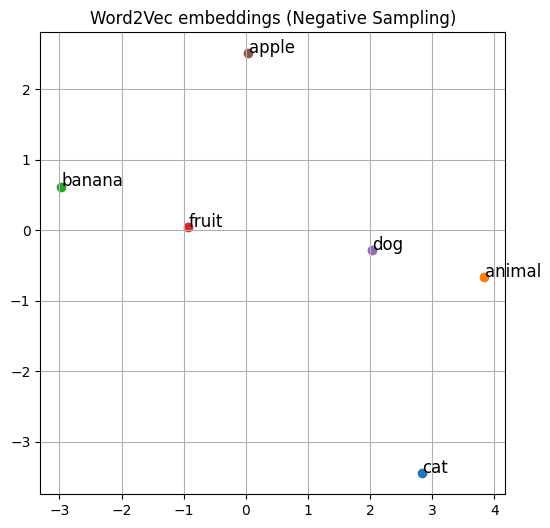

In [121]:
import matplotlib.pyplot as plt

# Get vectors
word_vectors = model.embedding_v.weight.detach().numpy()

plt.figure(figsize=(6,6))

for word, idx in word2index.items():
    if word == "<UNK>":
        continue
    x, y = word_vectors[idx]
    plt.scatter(x, y)
    plt.text(x + 0.01, y + 0.01, word, fontsize=12)

plt.title("Word2Vec embeddings (Negative Sampling)")
plt.grid(True)
plt.show()
